**This notebook shows how transfer learning and a set of training data can be used to improve the global temperature prediction. <br/>**

By Weiwei Zhan


We train NN models using two different settings, i.e., w/o and with transfer learning, and compare how the transfer learning and a set of training data affect our prediction:

**w/o transfer learning:** train a NN model from scratch by setting only one scenario as the traning set<br/>
**with transfer learning:** initialize the NN model with pre-trained weights and train the model with other scenarios (set the rest of the scenarios as the training set)


modified by Rong-Yu Gu, 11/14/23


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 
tf.random.set_seed(2022)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


2023-11-14 22:19:29.179906: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 22:19:29.218781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"


### 1. train & evaluate the vanilla Neural Network w/o transfer learning

#### data preprocessing - import data as training & test sets

training set: the `ssp126` scenarios <br/>
test set: the `ssp370` scenario

In [3]:
# Training set
# scenario_list  = ["historical", "ssp585", "ssp126", "ssp245", "ssp370", "hist-aer", "hist-GHG"]
train_files    = ["ssp126"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp370', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp370',data_path=test_path,time_reindex=False)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())



#### Data standardization

In [5]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(86, 2) (86, 13824) (86, 2)


#### define & train the vanilla Neural Network

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 200
learning_rate  = 1e-4
minibatch_size = 64
model_num      = 1
N_layers = 3


In [7]:
tf.random.set_seed(5)
model_vanilla = Sequential()

model_vanilla.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1", input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
for n in range(N_layers-1):
    model_vanilla.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 

model_vanilla.add(Dense(y_train.shape[1],  activation='linear', name="output_layer")) # the output layer


model_vanilla.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [8]:
model_vanilla.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                192       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 13824)             898560    
                                                                 
Total params: 907,072
Trainable params: 907,072
Non-trainable params: 0
_________________________________________________________________


In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model_vanilla.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])



Epoch 1/200
2/2 [==============================] - 1s 125ms/step - loss: 3.5163 - val_loss: 3.4872
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 3.5146 - val_loss: 3.4850
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 3.5127 - val_loss: 3.4828
Epoch 4/200
2/2 [==============================] - 0s 22ms/step - loss: 3.5109 - val_loss: 3.4804
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 3.5090 - val_loss: 3.4780
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 3.5070 - val_loss: 3.4755
Epoch 7/200
2/2 [==============================] - 0s 22ms/step - loss: 3.5049 - val_loss: 3.4728
Epoch 8/200
2/2 [==============================] - 0s 42ms/step - loss: 3.5027 - val_loss: 3.4700
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 3.5005 - val_loss: 3.4672
Epoch 10/200
2/2 [==============================] - 0s 22ms/step - loss: 3.4981 - val_loss: 3.4643
Epoch 11/200
2/2 [

#### save the vanilla model

In [10]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_vanilla.save(os.path.join(model_path,'pretrained_model.h5'))


#### evaluate the performance of the vanilla Neural Network (w/o transfer learning)

In [11]:
y_pre_vanilla = model_vanilla.predict(X_test)
y_pre_vanilla = y_pre_vanilla.reshape(y_pre_vanilla.shape[0], 96, 144)

y_pre_vanilla = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                           data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_pre_vanilla)))


3/3 [==============================] - 0s 2ms/step


plot the comparison between predictions from the vanilla model and the truth

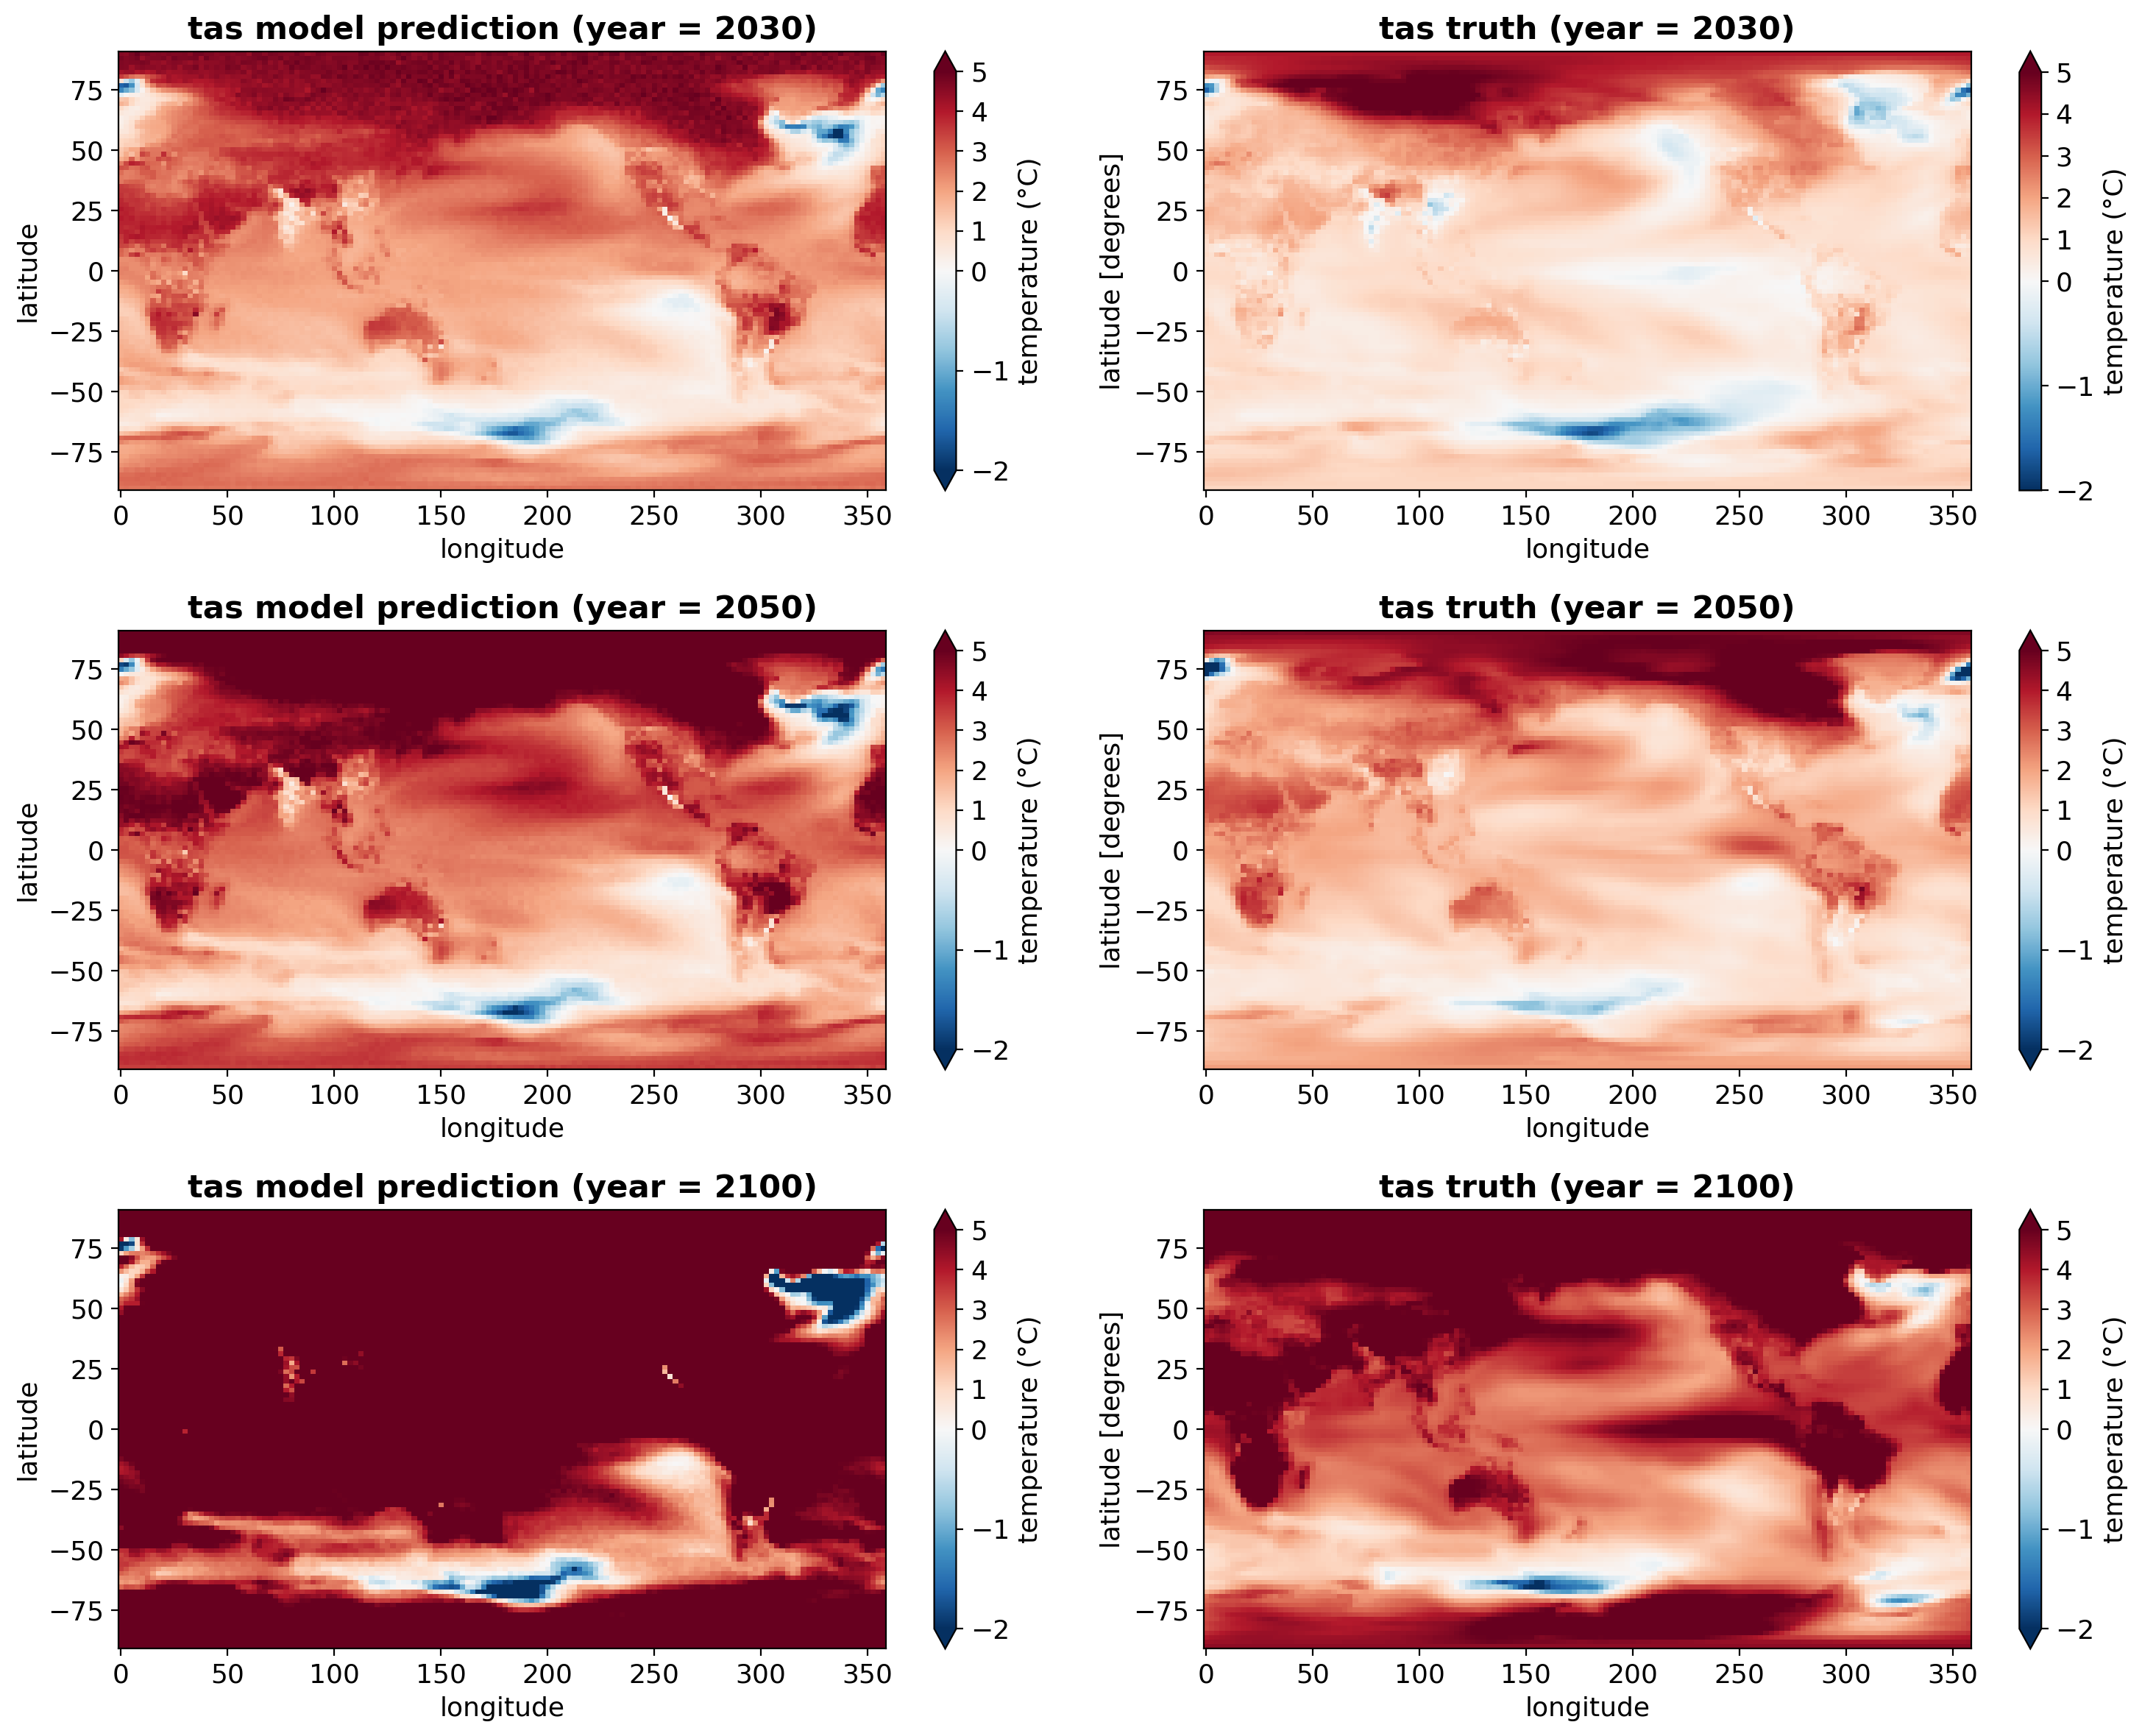

In [12]:
import matplotlib.colors as colors
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

y_pre_vanilla.tas.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()


### 2. train NN with transfer learning

Here we initialize the Neural Network with pre-trained weights and train the model with other scenarios

#### import the pre-trained model

In [13]:
model_path = os.path.join(cwd,'saved_model')
model_pretrain = load_model(os.path.join(model_path,'pretrained_model.h5'))


#### data preprocessing

* training set:`historical,ssp585,hist-aer,hist-GHG` (More scenarios were included in the model)
* test set:`ssp370`

In [14]:
# Training set
train_files    = ["historical", "ssp585", "hist-aer", "hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp370', data_path=train_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp370',data_path=train_path,time_reindex=False)

# Select variables used in the Neural Network
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(581, 2) (581, 13824) (86, 2)


#### train a NN model based on the previous pre-trained model 

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# or we can make the decision layer by layer
model_pretrain.get_layer("hidden_layer_1").trainable = False
model_pretrain.get_layer("hidden_layer_2").trainable = False
model_pretrain.get_layer("hidden_layer_3").trainable = True
model_pretrain.get_layer("output_layer").trainable = True
    

tf.random.set_seed(5)
history = model_pretrain.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/200
8/8 [==============================] - 0s 29ms/step - loss: 1.2967 - val_loss: 0.2543
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 1.1848 - val_loss: 0.2355
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 1.0569 - val_loss: 0.2196
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.9471 - val_loss: 0.2085
Epoch 5/200
8/8 [==============================] - 0s 15ms/step - loss: 0.8584 - val_loss: 0.2010
Epoch 6/200
8/8 [==============================] - 0s 24ms/step - loss: 0.7846 - val_loss: 0.1961
Epoch 7/200
8/8 [==============================] - 0s 17ms/step - loss: 0.7261 - val_loss: 0.1930
Epoch 8/200
8/8 [==============================] - 0s 15ms/step - loss: 0.6800 - val_loss: 0.1906
Epoch 9/200
8/8 [==============================] - 0s 18ms/step - loss: 0.6400 - val_loss: 0.1890
Epoch 10/200
8/8 [==============================] - 0s 15ms/step - loss: 0.6044 - val_loss: 0.1885
Epoch 11/200
8/8 [=

In [16]:
# generate predictions
y_pre_tl = model_pretrain.predict(X_test)
y_pre_tl = y_pre_tl.reshape(y_pre_tl.shape[0], 96, 144)

y_pre_tl = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_pre_tl)))


3/3 [==============================] - 0s 2ms/step


### 3. compare the predictions between vanilla NN (w/o transfer learning) and NN with transfer learning

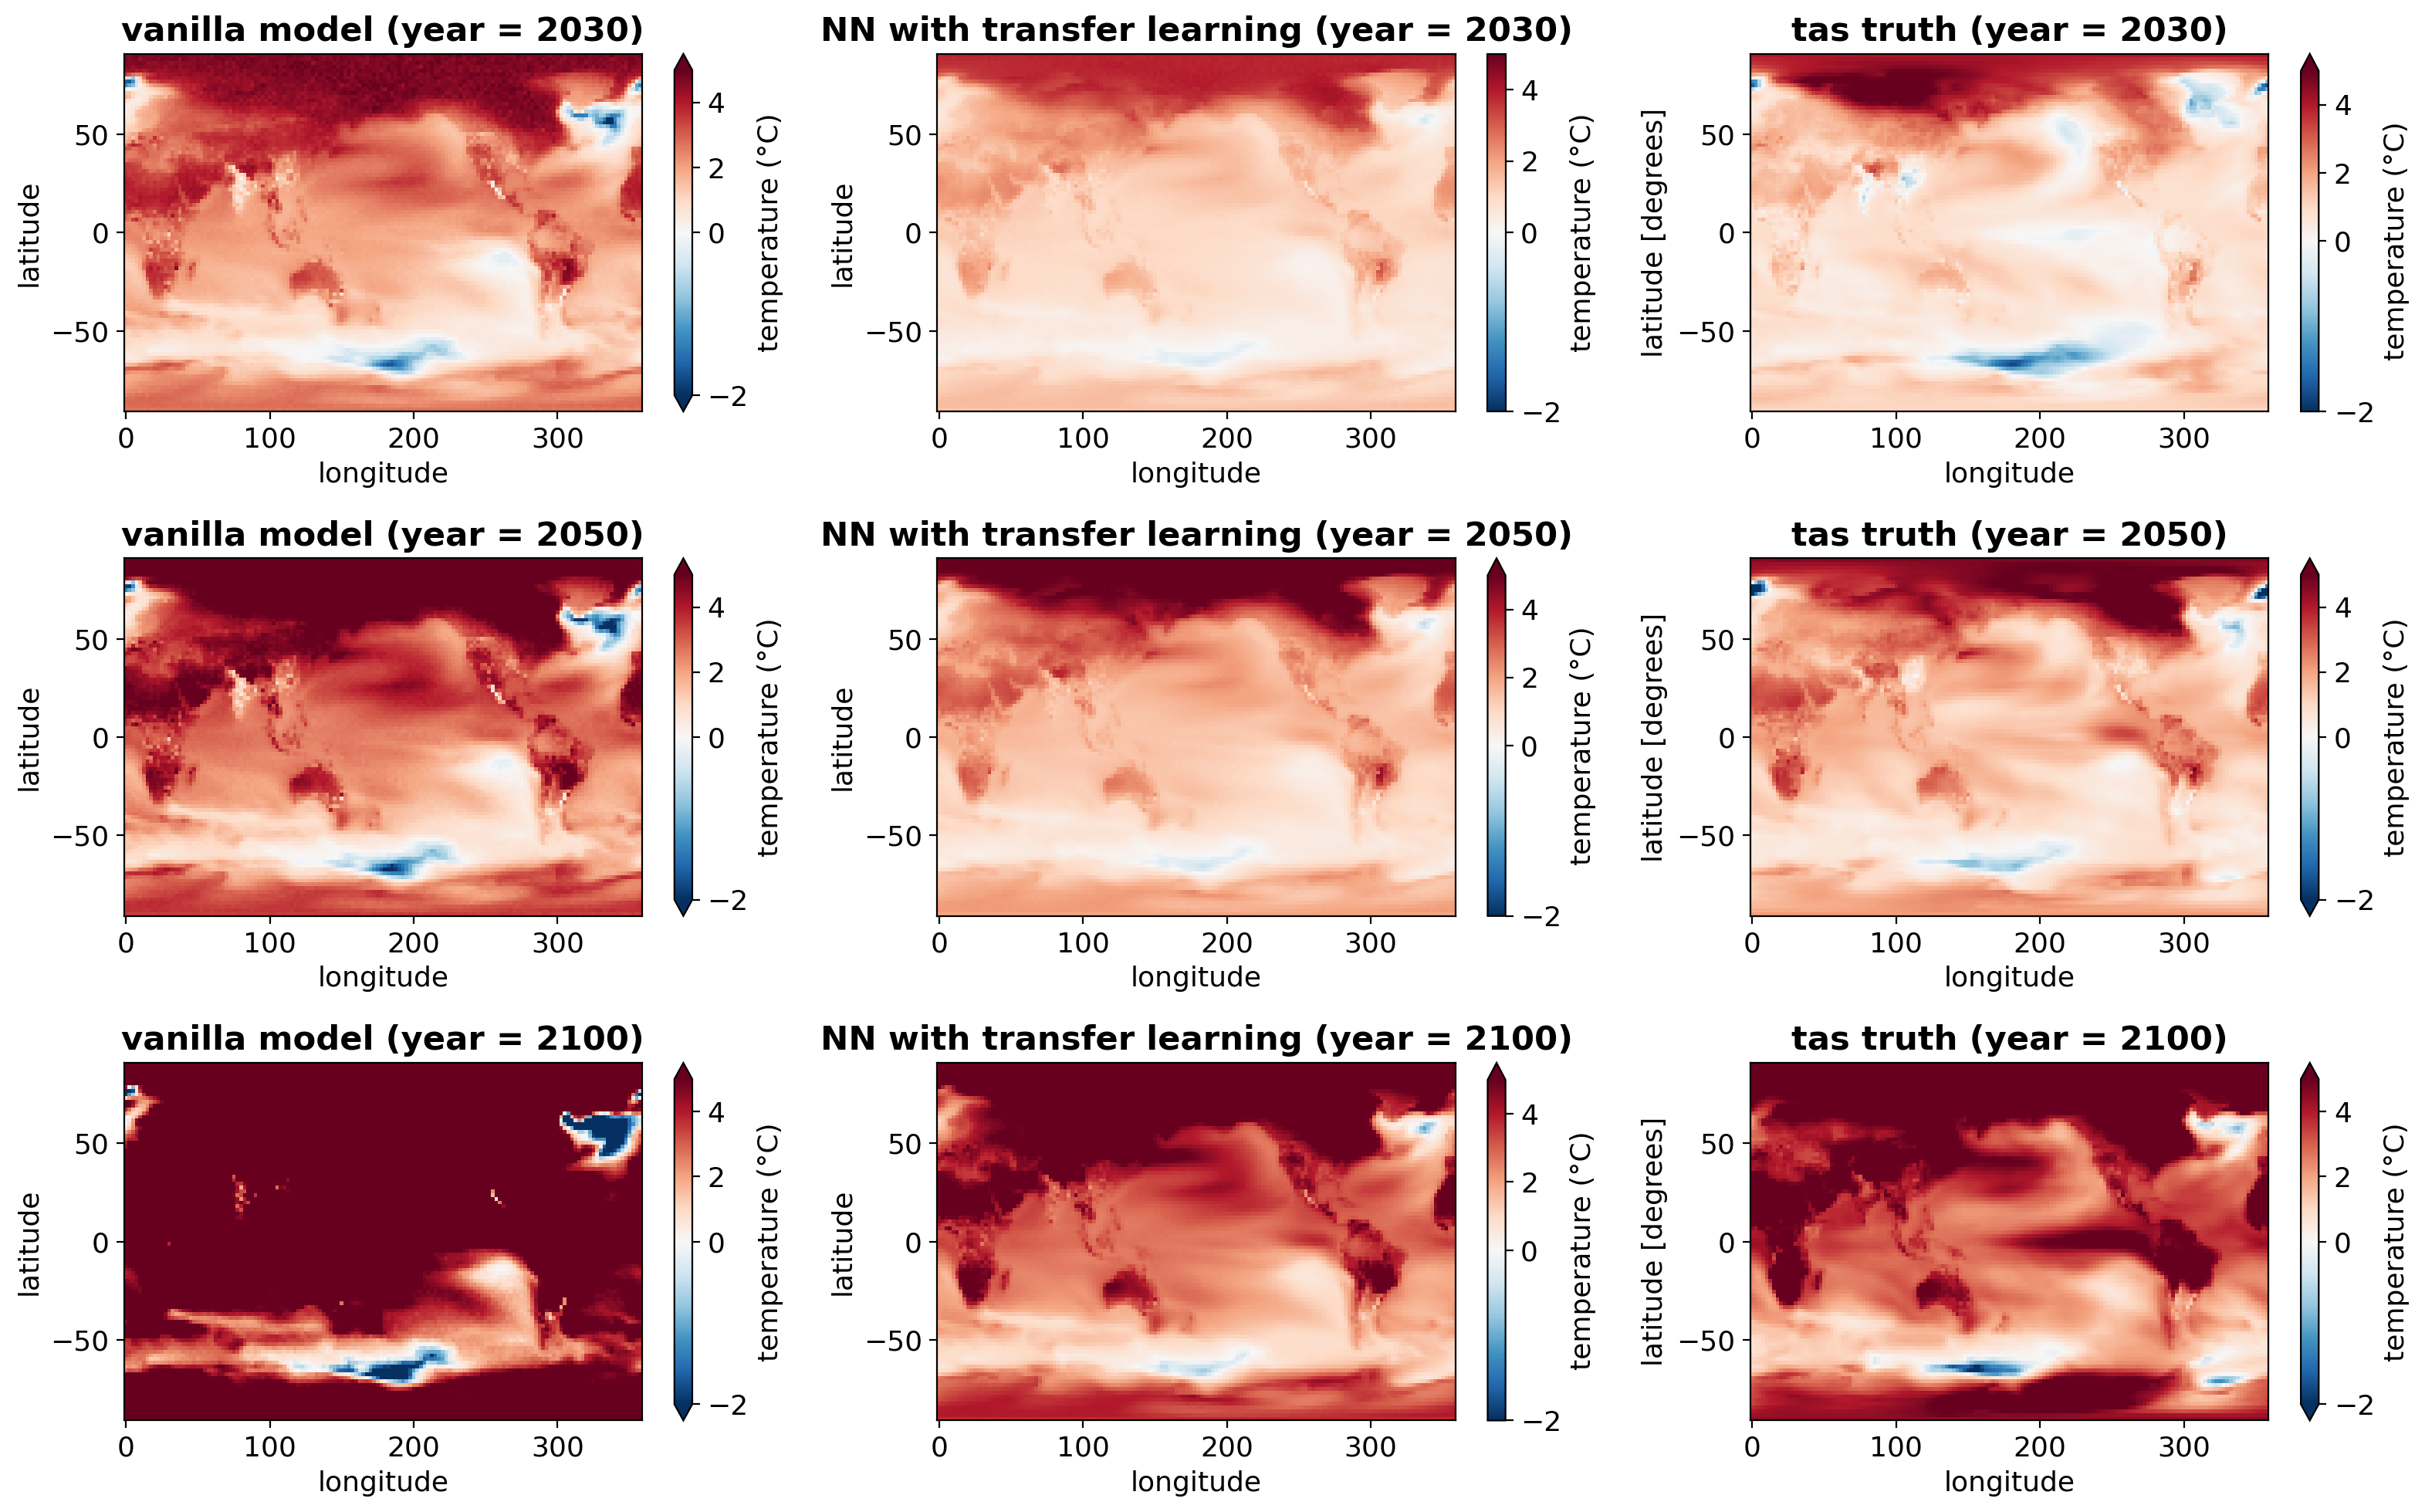

In [17]:
fig, axes = plt.subplots(figsize=(16,10),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

y_pre_vanilla.tas.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction without transfer learning
    if i % 3 == 0:
        ax.set_title(f'vanilla model (year = {yrs[i//3]})',fontweight='bold')
        
    # middle column: model prediction with transfer learning
    elif i % 3 == 1:
        ax.set_title(f'NN with transfer learning (year = {yrs[i//3]})',fontweight='bold')
    
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')


plt.tight_layout()


Then we also check whether the both model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

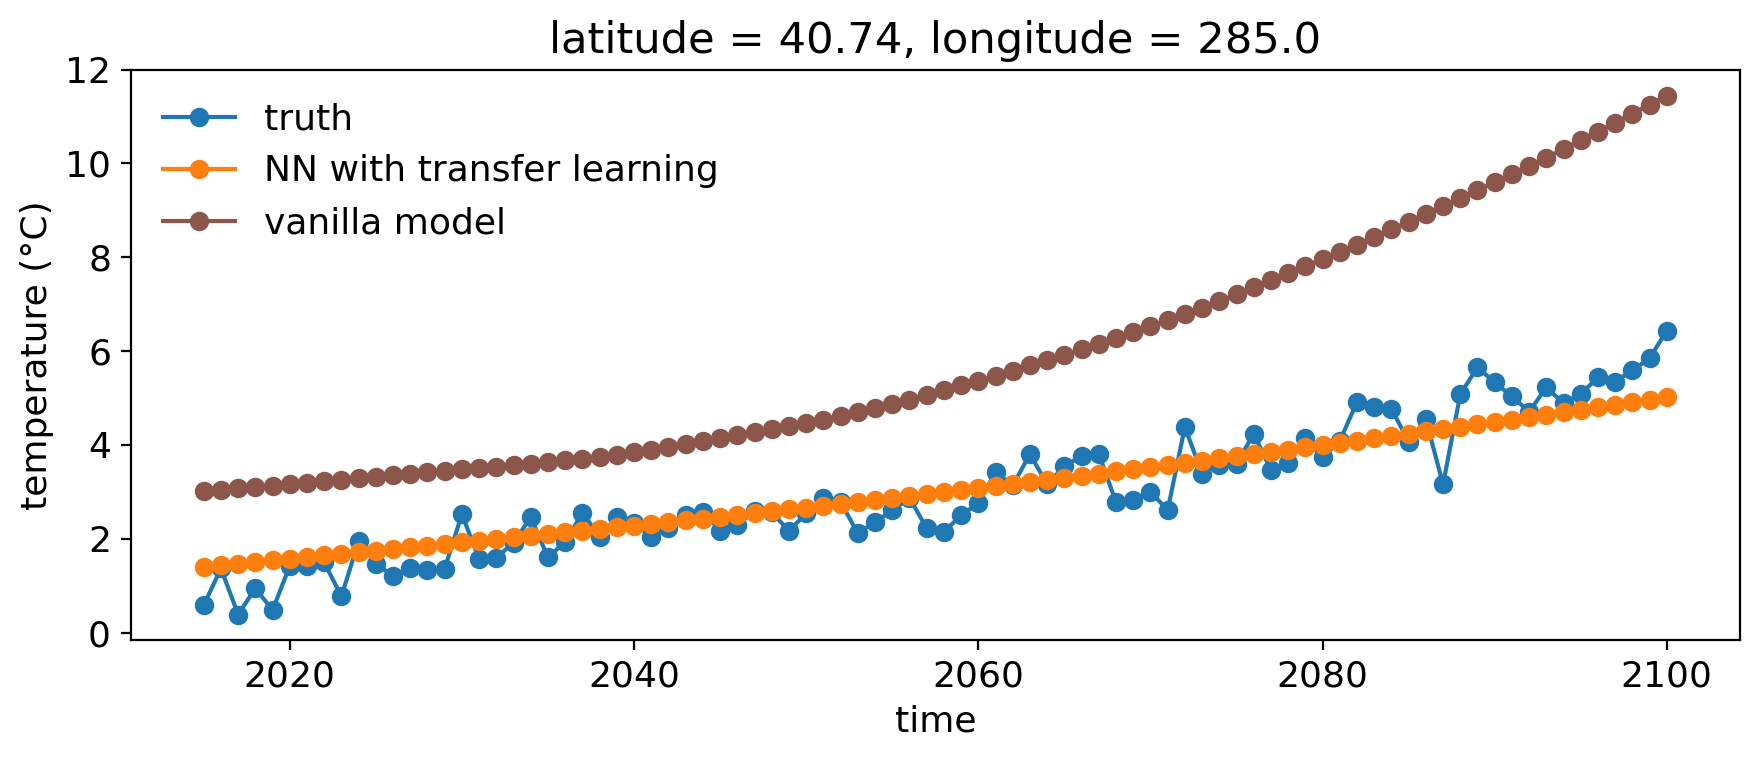

In [18]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:blue',
                                                                    label='truth')
y_pre_tl.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:orange',
                                                                   label='NN with transfer learning')
y_pre_vanilla.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',
                                                                        label='vanilla model')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()